## Importar librerias

In [3]:
# Manejo de datos
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Gráficos (Incluidos únicamente en el archivo .ipybn)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Preprocesado y modelado
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version skforecast: {skforecast.__version__}")
print(f"{color}- Version scikit-learn: {sklearn.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")

Versión de las librerias utilizadas:
- Version skforecast: 0.14.0
- Version scikit-learn: 1.5.0
- Version pandas: 2.2.3
- Version numpy: 1.26.4


## Funciones de utilidad

In [4]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

## Lectura del dataset

In [5]:
# Cargar el archivo Excel
df = pd.read_excel("Datasets/accesos.xlsx")

# Leer días de vacaciones desde un archivo txt
with open('Datasets/dias_vacaciones.txt', 'r') as f:
    dias_vacaciones = [pd.to_datetime(line.strip(), errors='coerce') for line in f if line.strip()]

# Asegurar que la fecha esté en formato datetime
df['Fecha Completa'] = pd.to_datetime(df['Fecha Completa'])

# Crear variables temporales relevantes
df['Día'] = df['Fecha Completa'].dt.day
df['Mes'] = df['Fecha Completa'].dt.month
df['Año'] = df['Fecha Completa'].dt.year

# Crear una clave de fecha sin hora
df['Fecha'] = df['Fecha Completa'].dt.date

# Crear columna exógena de vacaciones
df['Vacaciones'] = df['Fecha Completa'].dt.normalize().isin(dias_vacaciones).astype(int)

# Agrupar y contar accesos
daily_counts = df.groupby(['Fecha', 'Día', 'Mes', 'Año']).agg({
    'Fecha Completa': 'count',  # esto cuenta los accesos
    'Vacaciones': 'max'  # max para saber si es día de vacaciones
}).rename(columns={'Fecha Completa': 'Accesos'}).reset_index()

# Crear rango completo de fechas
fecha_inicio = df['Fecha'].min()
fecha_fin = df['Fecha'].max()
fechas_completas = pd.DataFrame({'Fecha': pd.date_range(fecha_inicio, fecha_fin)})

# Extraer día, mes y año para el rango completo
fechas_completas['Día'] = fechas_completas['Fecha'].dt.day
fechas_completas['Mes'] = fechas_completas['Fecha'].dt.month
fechas_completas['Año'] = fechas_completas['Fecha'].dt.year
fechas_completas['Fecha'] = fechas_completas['Fecha'].dt.date 

# Marcar vacaciones en el rango completo
fechas_completas['Vacaciones'] = pd.to_datetime(fechas_completas['Fecha']).isin(dias_vacaciones).astype(int)

# Unir con daily_counts
daily_counts_full = fechas_completas.merge(
    daily_counts.drop(columns=['Vacaciones']),  # quitamos la columna para evitar duplicados
    on=['Fecha', 'Día', 'Mes', 'Año'],
    how='left'
)

In [6]:
# Rellenar NaN con 0 en las columnas numéricas
for col in ['Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)

# Eliminar los domingos del DataFrame
daily_counts_full = daily_counts_full[
    pd.to_datetime(daily_counts_full['Fecha']).dt.weekday != 6
].reset_index(drop=True)

# Incluir la columna de día de la semana
daily_counts_full['Dia_Semana'] = pd.to_datetime(daily_counts_full['Fecha']).dt.weekday

# Crear columna que marca los sábados (sábado=5)
daily_counts_full['Es_Sabado'] = (daily_counts_full['Dia_Semana'] == 5).astype(int)

In [7]:
daily_counts_full.head(10)

,Fecha,Día,Mes,Año,Vacaciones,Accesos,Dia_Semana,Es_Sabado
0,2023-12-14,14,12,2023,0,953,3,0
1,2023-12-15,15,12,2023,0,549,4,0
2,2023-12-16,16,12,2023,0,71,5,1
3,2023-12-18,18,12,2023,0,739,0,0
4,2023-12-19,19,12,2023,0,383,1,0
5,2023-12-20,20,12,2023,0,239,2,0
6,2023-12-21,21,12,2023,0,211,3,0
7,2023-12-22,22,12,2023,1,122,4,0
8,2023-12-23,23,12,2023,0,0,5,1
9,2023-12-25,25,12,2023,1,0,0,0


In [8]:
daily_counts_full.tail(10)

,Fecha,Día,Mes,Año,Vacaciones,Accesos,Dia_Semana,Es_Sabado
428,2025-04-26,26,4,2025,0,526,5,1
429,2025-04-28,28,4,2025,0,2400,0,0
430,2025-04-29,29,4,2025,0,2568,1,0
431,2025-04-30,30,4,2025,0,1705,2,0
432,2025-05-01,1,5,2025,1,0,3,0
433,2025-05-02,2,5,2025,1,0,4,0
434,2025-05-03,3,5,2025,0,0,5,1
435,2025-05-05,5,5,2025,0,2750,0,0
436,2025-05-06,6,5,2025,0,1866,1,0
437,2025-05-07,7,5,2025,0,2254,2,0


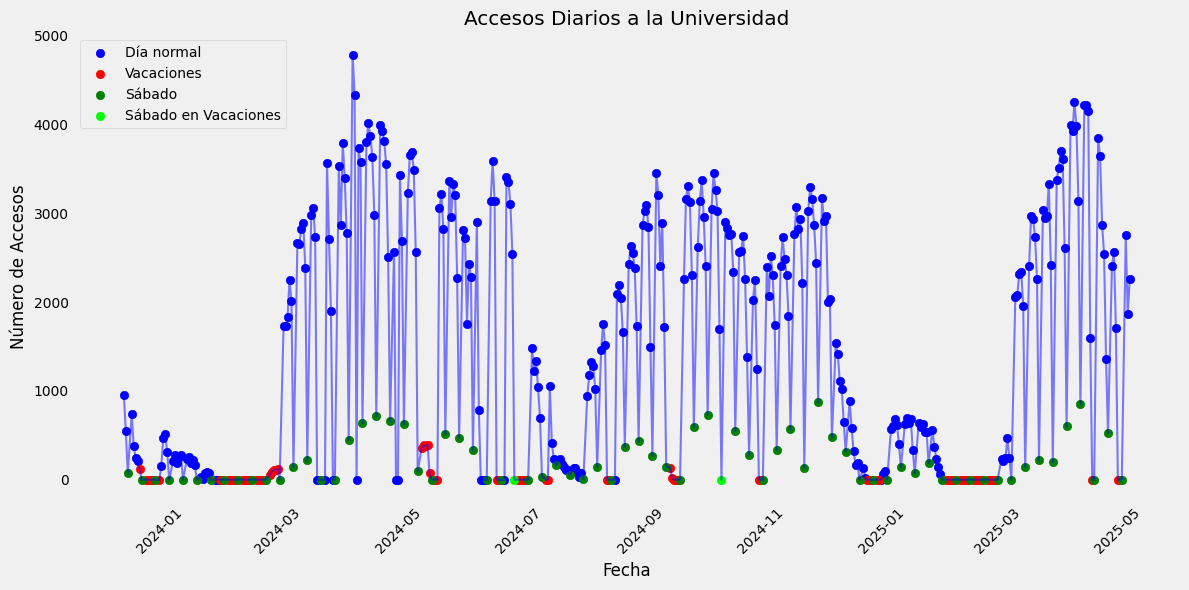

In [9]:
# Graficar los datos con puntos rojos en vacaciones y verdes en sábados
plt.figure(figsize=(12, 6))

# Línea general
plt.plot(daily_counts_full['Fecha'], daily_counts_full['Accesos'], linestyle='-', color='b', alpha=0.5)

# Puntos normales (no vacaciones ni sábados)
no_vac_no_sab = (daily_counts_full['Vacaciones'] == 0) & (daily_counts_full['Es_Sabado'] == 0)
plt.scatter(daily_counts_full['Fecha'][no_vac_no_sab], daily_counts_full['Accesos'][no_vac_no_sab], color='b', label='Día normal')

# Puntos de vacaciones (no sábado)
vac = (daily_counts_full['Vacaciones'] == 1) & (daily_counts_full['Es_Sabado'] == 0)
plt.scatter(daily_counts_full['Fecha'][vac], daily_counts_full['Accesos'][vac], color='r', label='Vacaciones')

# Puntos de sábados (no vacaciones)
sab = (daily_counts_full['Es_Sabado'] == 1) & (daily_counts_full['Vacaciones'] == 0)
plt.scatter(daily_counts_full['Fecha'][sab], daily_counts_full['Accesos'][sab], color='g', label='Sábado')

# Puntos de sábados en vacaciones (opcional, mezcla de ambos)
sab_vac = (daily_counts_full['Es_Sabado'] == 1) & (daily_counts_full['Vacaciones'] == 1)
plt.scatter(daily_counts_full['Fecha'][sab_vac], daily_counts_full['Accesos'][sab_vac], color='lime', label='Sábado en Vacaciones')

plt.title('Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## División de datos de entrenamiento y test


In [42]:
from sklearn.model_selection import train_test_split

for lag in [7, 14, 21]:
    daily_counts_full[f'lag_{lag}'] = daily_counts_full['Accesos'].shift(lag)

# Elimina las filas con NaN generadas por el shift
daily_counts_full = daily_counts_full.dropna().reset_index(drop=True)

# Incluye los lags en X
X = daily_counts_full[['Vacaciones', 'Dia_Semana', 'Es_Sabado', 'lag_7', 'lag_14', 'lag_21']]
y = daily_counts_full['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de prueba: {len(X_test)}")

Datos de entrenamiento: 316
Datos de prueba: 80


## Crear modelo


In [43]:
model = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    learning_rate = 0.3, 
    max_depth = 3, 
    n_estimators = 100
    )
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [44]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)
# Definir el espacio de búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}
# Grid Search con TimeSeriesSplit
grid_search = GridSearchCV(
    xgb.XGBRegressor(),
    param_grid, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print(f'Mejores parámetros: {grid_search.best_params_}')

Mejores parámetros: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


In [45]:
model = xgb.XGBRegressor(
    colsample_bytree = 1,
    objective ='reg:squarederror', 
    learning_rate = 0.01, 
    max_depth = 3, 
    n_estimators = 200,
    subsample = 1
    )
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Evaluación de rendimiento

In [46]:
predicted = model.predict(X_test)

In [47]:
predicted

array([ 1.38591675e+02, -2.25702477e+01, -2.25702477e+01, -2.18219585e+01,
        1.15712433e+02,  9.85546494e+01,  3.07074909e+01, -3.07986145e+01,
       -2.10558167e+01, -4.22790718e+00,  1.25455215e+02,  1.19781311e+02,
        3.07074909e+01, -4.22790718e+00, -4.22790718e+00, -4.22790718e+00,
        1.25455215e+02,  1.19781311e+02,  3.07074909e+01, -2.07079577e+00,
       -2.07079577e+00, -2.07079577e+00,  1.25455215e+02,  1.39991614e+03,
        1.30486121e+03,  1.26805151e+03,  1.25095850e+03,  8.51848267e+02,
        1.25455215e+02,  1.39991614e+03,  1.30486121e+03,  1.26805151e+03,
        1.25095850e+03,  8.51848267e+02,  1.25455215e+02,  1.39991614e+03,
        1.97299316e+03,  1.89660754e+03,  1.87230627e+03,  1.35071838e+03,
        3.37918213e+02,  1.39991614e+03,  2.03719946e+03,  1.93610168e+03,
        1.90004871e+03,  1.33896667e+03,  3.26166443e+02,  1.50636963e+03,
        2.28911694e+03,  1.94795435e+03,  1.86166614e+03,  2.08978833e+03,
        3.81655151e+02,  

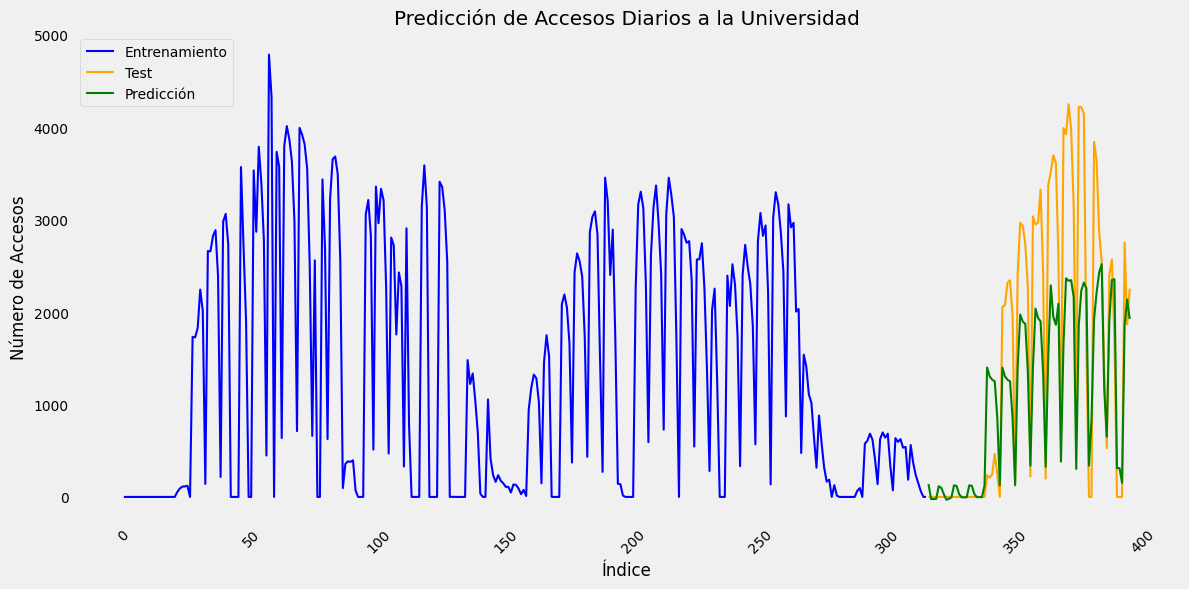

Error Cuadrático Medio (MSE): 881542.33
Error Absoluto Medio (MAE): 673.44
Error Porcentual Absoluto Medio (SMAPE): 106.41%


In [48]:
# Graficar resultados y calcular métricas para XGBoost
plt.figure(figsize=(12, 6))
plt.plot(X_train.index, y_train, label='Entrenamiento', color='blue')
plt.plot(X_test.index, y_test, label='Test', color='orange')
plt.plot(X_test.index, predicted, label='Predicción', color='green')
plt.title('Predicción de Accesos Diarios a la Universidad')
plt.xlabel('Índice')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Evaluación del modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predicted)
mae = mean_absolute_error(y_test, predicted)
smape_value = smape(y_test, predicted)
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Error Porcentual Absoluto Medio (SMAPE): {smape_value:.2f}%")

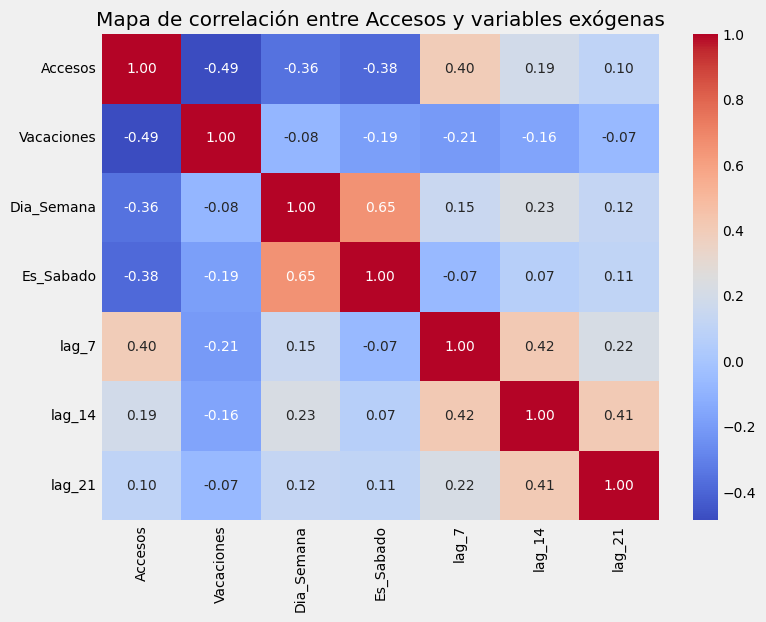

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecciona solo las columnas numéricas relevantes
corr_df = daily_counts_full[['Accesos', 'Vacaciones', 'Dia_Semana', 'Es_Sabado', 'lag_7', 'lag_14', 'lag_21']].copy()

# Calcula la matriz de correlación
corr_matrix = corr_df.corr()

# Mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de correlación entre Accesos y variables exógenas')
plt.show()

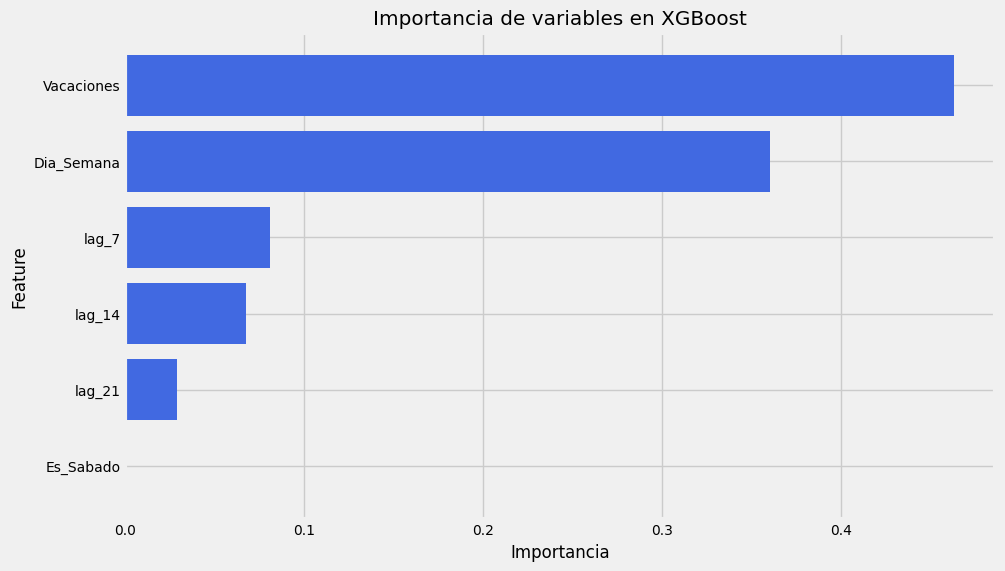

In [51]:
import matplotlib.pyplot as plt

# Obtener importancia de las características
importances = model.feature_importances_

# Usar las columnas de X_train como nombres de las variables
features = X_train.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='royalblue')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Importancia de variables en XGBoost")
plt.gca().invert_yaxis()  # Para que la más importante aparezca arriba
plt.show()